# Predicción del precion Airbnb Madrid España: Pre-procesamiento y Modelado 

<div class="alert alert-info alert-info"><b><h1>Objetivo</h1></b>
    
**Crear un modelos de regresión lineal con el dataset previamente analizaado, asi como utilizar las métricas para interpretar los resultados.**
</div>

## 1. Introducción:  

En el notebook anterior se realizó un análisis detallado de los precios de Airbnb en Madrid. Se llevaron a cabo los siguientes pasos: Descripción de Datos, Limpieza y Preparación de Datos, y Visualización de Datos. Ahora, nos enfocaremos en aplicar técnicas de modelado y verificación del modelo para predecir los precios de los listados en Madrid. El objetivo final es desarrollar un modelo predictivo con regressión lineal, que pueda ayudar a sugerir precios para futuros listados de Airbnb en la ciudad.

## 2. Variables:  


---

## 3. Librerías a utilizar

In [1]:
# import libreries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joypy
from joypy import joyplot


# Import the module for the split
from sklearn.model_selection import train_test_split

#import libreries to statitics
from scipy import stats
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols

#Import the module for the preprocessing
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

---

## 4. Dataset

In [2]:
df_airbnb_clean = pd.read_csv('/home/neivysg/keepcoding_glovo_bootcamp/Tech-Girls-Glovo/data/processed/processed-air-bnb-listings.csv', 
                              sep=';', 
                              encoding='UTF-8')

In [3]:
df_airbnb_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Room.ID                      21255 non-null  int64 
 1   Name                         21252 non-null  object
 2   Host.ID                      21255 non-null  int64 
 3   Neighbourhood                21255 non-null  object
 4   Room.type                    21255 non-null  object
 5   Room.Price                   21255 non-null  int64 
 6   Minimum.nights               21255 non-null  int64 
 7   Number.of.reviews            21255 non-null  int64 
 8   Date.last.review             15855 non-null  object
 9   Number.of.reviews.per.month  21255 non-null  object
 10  Rooms.rent.by.the.host       21255 non-null  int64 
 11  Updated.Date                 21255 non-null  object
 12  City                         21255 non-null  object
 13  Country                      21

In [4]:
df_airbnb_clean.head()

,Room.ID,Name,Host.ID,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Date.last.review,Number.of.reviews.per.month,Rooms.rent.by.the.host,Updated.Date,City,Country,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,21859113,Be Mate Plaza España Wild 203,157114944,Argüelles,Entire home/apt,147,1,1,2018-12-01,"0,05",36,2020-07-17,Madrid,Spain,"40,4219118238299","-3,71629887503917",No disponible,0-1/mes,1 reseña,1+ año
1,21862103,Designer flat in Madrid's exclusive Salamanca ...,8851341,Recoletos,Entire home/apt,625,5,2,2018-08-09,"0,06",1,2020-07-17,Madrid,Spain,"40,4220548771786","-3,68896132029749",91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,21875158,Estudio de diseño en pleno centro de Madrid,159570292,Sol,Private room,500,1,110,2020-02-26,"3,41",2,2020-07-17,Madrid,Spain,"40,4157379439854","-3,70441664509817",181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,21932504,Cosy apartment in the cosmopolitan Gran Vía,160055902,Palacio,Entire home/apt,62,2,194,2020-03-11,"6,16",1,2020-07-17,Madrid,Spain,"40,421747567976","-3,71099451203024",181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,22042300,Habitación 1. Para estudiar o trabajar,160981040,Portazgo,Private room,12,15,11,2018-10-30,"0,4",3,2020-07-17,Madrid,Spain,"40,391493766002","-3,64508317610579",91 a 180 días,0-1/mes,11-50 reseñas,1+ año


## 4. Análisis General

### 4.1. Verificar nulos y NaM

In [5]:
df_airbnb_clean.isnull().sum()

Room.ID                           0
Name                              3
Host.ID                           0
Neighbourhood                     0
Room.type                         0
Room.Price                        0
Minimum.nights                    0
Number.of.reviews                 0
Date.last.review               5400
Number.of.reviews.per.month       0
Rooms.rent.by.the.host            0
Updated.Date                      0
City                              0
Country                           0
Latitude                          0
Longitude                         0
Availability_Cat                  0
Review_category                   0
Review_Count_Category             0
Time_category                     0
dtype: int64

In [6]:
df_airbnb_clean.isna().sum()

Room.ID                           0
Name                              3
Host.ID                           0
Neighbourhood                     0
Room.type                         0
Room.Price                        0
Minimum.nights                    0
Number.of.reviews                 0
Date.last.review               5400
Number.of.reviews.per.month       0
Rooms.rent.by.the.host            0
Updated.Date                      0
City                              0
Country                           0
Latitude                          0
Longitude                         0
Availability_Cat                  0
Review_category                   0
Review_Count_Category             0
Time_category                     0
dtype: int64

### 4.2. Verificar datos duplicados

In [7]:
df_airbnb_clean[df_airbnb_clean.duplicated()]

,Room.ID,Name,Host.ID,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Date.last.review,Number.of.reviews.per.month,Rooms.rent.by.the.host,Updated.Date,City,Country,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category


<h3>Observaciones:</h3>

   *  Se puede observar que el dataset  tiene valores nulos o NaN enlas columnas names y Date.last.review. 
   *  Se puede observar que el data set no tiene valores duplicados.   
   * Se tienen 14 variables objetos y 6 integer.
   * Basado en el Análisis Exploratorio previo (Cuaderno R) se tienen seleccionadas inicialmente para el modelo de prediccion los siguientes atributos, sin embargo previó se realizará un analisis estadistico preliminar a la seleccion final o caso base:
      - Numéricas: Minimum.nights, Number.of.reviews, Number.of.reviews.per.month, Latitude, Longitude.
      - Categóricas: Neighbourhood, Room.type, Availability_Cat, Review_category, Review_Count_Category, Time_category.
   * Se descartarás los atributos: Room.ID, Name, Host.ID, Date.last.review, Updated.Date, City, Country. 

### 4.4. Eliminar atributos

De acuerdo al analisis exploratorios previos, se eliminaran los atributos: Room.ID, Name, Host.ID, Date.last.review, Updated.Date, City, Country, como primer descarte.

In [8]:
df_airbnb_clean_vs_1 = df_airbnb_clean.drop(['Room.ID', 'Name', 'Host.ID', 'Date.last.review', 'Updated.Date', 'City', 'Country'], axis=1)

In [9]:
df_airbnb_clean_vs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Neighbourhood                21255 non-null  object
 1   Room.type                    21255 non-null  object
 2   Room.Price                   21255 non-null  int64 
 3   Minimum.nights               21255 non-null  int64 
 4   Number.of.reviews            21255 non-null  int64 
 5   Number.of.reviews.per.month  21255 non-null  object
 6   Rooms.rent.by.the.host       21255 non-null  int64 
 7   Latitude                     21255 non-null  object
 8   Longitude                    21255 non-null  object
 9   Availability_Cat             21255 non-null  object
 10  Review_category              21255 non-null  object
 11  Review_Count_Category        21255 non-null  object
 12  Time_category                21255 non-null  object
dtypes: int64(4), object(9)
memory u

### 4.3. Verificar tipos de datos

In [10]:
# Verificar tipos de datos
print(df_airbnb_clean_vs_1.dtypes)

Neighbourhood                  object
Room.type                      object
Room.Price                      int64
Minimum.nights                  int64
Number.of.reviews               int64
Number.of.reviews.per.month    object
Rooms.rent.by.the.host          int64
Latitude                       object
Longitude                      object
Availability_Cat               object
Review_category                object
Review_Count_Category          object
Time_category                  object
dtype: object


Dado que Latitude, Longitude y Number.of.reviews.per.month están etiquetados como object, necesitamos convertir estas columnas a tipo numérico

In [11]:
# Convertir columnas a tipo numérico
df_airbnb_clean_vs_1['Latitude'] = df_airbnb_clean_vs_1['Latitude'].str.replace(',', '.').astype(float)
df_airbnb_clean_vs_1['Longitude'] = df_airbnb_clean_vs_1['Longitude'].str.replace(',', '.').astype(float)
df_airbnb_clean_vs_1['Number.of.reviews.per.month'] = df_airbnb_clean_vs_1['Number.of.reviews.per.month'].str.replace(',', '.').astype(float)

In [12]:
df_airbnb_clean_vs_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21255 entries, 0 to 21254
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Neighbourhood                21255 non-null  object 
 1   Room.type                    21255 non-null  object 
 2   Room.Price                   21255 non-null  int64  
 3   Minimum.nights               21255 non-null  int64  
 4   Number.of.reviews            21255 non-null  int64  
 5   Number.of.reviews.per.month  21255 non-null  float64
 6   Rooms.rent.by.the.host       21255 non-null  int64  
 7   Latitude                     21255 non-null  float64
 8   Longitude                    21255 non-null  float64
 9   Availability_Cat             21255 non-null  object 
 10  Review_category              21255 non-null  object 
 11  Review_Count_Category        21255 non-null  object 
 12  Time_category                21255 non-null  object 
dtypes: float64(3), i

In [13]:
df_airbnb_clean_vs_1.head()

,Neighbourhood,Room.type,Room.Price,Minimum.nights,Number.of.reviews,Number.of.reviews.per.month,Rooms.rent.by.the.host,Latitude,Longitude,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Argüelles,Entire home/apt,147,1,1,0.05,36,40.421912,-3.716299,No disponible,0-1/mes,1 reseña,1+ año
1,Recoletos,Entire home/apt,625,5,2,0.06,1,40.422055,-3.688961,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Sol,Private room,500,1,110,3.41,2,40.415738,-3.704417,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Palacio,Entire home/apt,62,2,194,6.16,1,40.421748,-3.710995,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Portazgo,Private room,12,15,11,0.40,3,40.391494,-3.645083,91 a 180 días,0-1/mes,11-50 reseñas,1+ año


### 4.4. Descripción estadistica y visualización global de las variables.

Para determinar qué variables mantener para el modelo de predicción, necesitamos evaluar su correlación con el precio de la habitación (Room.Price) y considerar otras técnicas estadísticas. Los pasos serán:

1. Sumario estadistico: Numericas y categoricas.
2. Evaluar la correlación: Ver la correlación de los atributos numericos con Room.Price.
3. Análisis de varianza: Evaluar variables categóricas con ANOVA.
4. Aplicación de prueba de hipotesis para chequear distribución normal

#### 4.4.1 Sumario Estadistico:

##### Variables Numéricas

In [14]:
def estadisticos_num(cont_data):
    #Calculamos describe
    estadisticos = cont_data.describe().round(3).T
    #Añadimos la mediana
    estadisticos['median'] = cont_data.median().round(3)
    #Reordenamos para que la mediana esté al lado de la media
    estadisticos = estadisticos.iloc[:,[0,1,8,2,3,4,5,6,7]]
    #Lo devolvemos
    return(estadisticos)

In [15]:
# Aplicamos la funcion a las variables numericcas
Num_data = df_airbnb_clean_vs_1.select_dtypes(['float64', 'int64'])
Num_data

,Room.Price,Minimum.nights,Number.of.reviews,Number.of.reviews.per.month,Rooms.rent.by.the.host,Latitude,Longitude
0,147,1,1,0.05,36,40.421912,-3.716299
1,625,5,2,0.06,1,40.422055,-3.688961
2,500,1,110,3.41,2,40.415738,-3.704417
3,62,2,194,6.16,1,40.421748,-3.710995
4,12,15,11,0.40,3,40.391494,-3.645083
...,...,...,...,...,...,...,...
21250,59,1,0,0.00,1,40.432952,-3.652199
21251,120,1,7,0.22,23,40.392654,-3.716037
21252,90,1,57,1.76,1,40.429886,-3.721570
21253,48,30,57,1.77,1,40.410442,-3.702625


In [16]:
estadisticos_num(Num_data)

,count,mean,median,std,min,25%,50%,75%,max
Room.Price,21255.0,163.985,60.000,559.471,0.000,36.000,60.000,100.000,9999.000
Minimum.nights,21255.0,5.522,2.000,28.147,1.000,1.000,2.000,3.000,1125.000
Number.of.reviews,21255.0,34.875,6.000,65.110,0.000,0.000,6.000,38.000,661.000
Number.of.reviews.per.month,21255.0,1.065,0.390,1.508,0.000,0.000,0.390,1.540,27.250
Rooms.rent.by.the.host,21255.0,14.246,2.000,39.299,1.000,1.000,2.000,7.000,244.000
Latitude,21255.0,40.421,40.420,0.022,40.332,40.410,40.420,40.430,40.563
Longitude,21255.0,-3.694,-3.701,0.028,-3.864,-3.708,-3.701,-3.687,-3.524


**Observaciones:**

* Room.Price: El precio medio de una habitación es de aproximadamente 164, pero la mediana es solo 60, lo que indica que hay algunos valores extremadamente altos (como el máximo de 9999) que están elevando la media. El 75% de las habitaciones cuestan 100 o menos.

* Minimum.nights: La mayoría de las estancias requieren muy pocas noches, con una mediana de solo 2 noches. Sin embargo, el máximo es de 1125 noches, lo que indica que hay algunas estancias que requieren estancias extremadamente largas.

* Number.of.reviews: La mayoría de las habitaciones tienen pocas reseñas, con una mediana de solo 6 reseñas. Sin embargo, la media es de 34.875, lo que indica que hay algunas habitaciones con un número muy alto de reseñas.

* Number.of.reviews.per.month: Similar a Number.of.reviews, la mayoría de las habitaciones tienen pocas reseñas por mes, pero hay algunas habitaciones con un número muy alto de reseñas por mes.

* Rooms.rent.by.the.host: La mayoría de los anfitriones alquilan pocas habitaciones, con una mediana de solo 2 habitaciones. Sin embargo, el máximo es de 244, lo que indica que hay algunos anfitriones que alquilan un gran número de habitaciones.

* Latitude y Longitude: Estas son las coordenadas geográficas de las habitaciones. No hay mucho que analizar aquí sin un contexto geográfico adicional.

En general, parece que hay una gran variabilidad en los datos, con algunos valores extremos en varias columnas. Esto podría afectar a los modelos de machine learning si no se manejan adecuadamente. En el caso de La discretización es una buena estrategia para manejar variables numéricas con muchos valores únicos o con valores extremos. Al convertir "Number.of.reviews" y "Number.of.reviews.per.month" en categorías, reduces la complejidad de los datos y puedes ayudar a tu modelo a capturar patrones más generales.

##### Variables Categoricas

In [17]:
cat = df_airbnb_clean_vs_1.select_dtypes('object')
cat

,Neighbourhood,Room.type,Availability_Cat,Review_category,Review_Count_Category,Time_category
0,Argüelles,Entire home/apt,No disponible,0-1/mes,1 reseña,1+ año
1,Recoletos,Entire home/apt,91 a 180 días,0-1/mes,2-10 reseñas,1+ año
2,Sol,Private room,181 a 365 días,1-5/mes,+ 101 reseñas,8 semanas - 6 meses
3,Palacio,Entire home/apt,181 a 365 días,+5/mes,+ 101 reseñas,8 semanas - 6 meses
4,Portazgo,Private room,91 a 180 días,0-1/mes,11-50 reseñas,1+ año
...,...,...,...,...,...,...
21250,Quintana,Private room,61 a 90 días,sin reseñas,sin reseñas,sin reseñas
21251,Opañel,Entire home/apt,No disponible,0-1/mes,2-10 reseñas,1+ año
21252,Argüelles,Entire home/apt,181 a 365 días,1-5/mes,51-100 reseñas,6-12 meses
21253,Embajadores,Entire home/apt,31 a 60 días,1-5/mes,51-100 reseñas,8 semanas - 6 meses


In [18]:
cat.describe()

,Neighbourhood,Room.type,Availability_Cat,Review_category,Review_Count_Category,Time_category
count,21255,21255,21255,21255,21255,21255
unique,127,4,6,4,6,5
top,Embajadores,Entire home/apt,181 a 365 días,0-1/mes,sin reseñas,8 semanas - 6 meses
freq,2559,12704,8186,8771,5400,7150


**Observaciones:**

* Neighbourhood: Hay 21255 observaciones no nulas, 127 barrios únicos, el barrio más común es "Embajadores", y "Embajadores" aparece 2559 veces.

* Room.type: Hay 21255 observaciones no nulas, 4 tipos de habitaciones únicos, el tipo de habitación más común es "Entire home/apt", y "Entire home/apt" aparece 12704 veces.

* Availability_Cat: Hay 21255 observaciones no nulas, 6 categorías de disponibilidad únicas, la categoría de disponibilidad más común es "181 a 365 días", y "181 a 365 días" aparece 8186 veces.

* Review_category: Hay 21255 observaciones no nulas, 4 categorías de revisión únicas, la categoría de revisión más común es "0-1/mes", y "0-1/mes" aparece 8771 veces.

* Review_Count_Category: Hay 21255 observaciones no nulas, 6 categorías de conteo de revisión únicas, la categoría de conteo de revisión más común es "sin reseñas", y "sin reseñas" aparece 5400 veces.

* Time_category: Hay 21255 observaciones no nulas, 5 categorías de tiempo únicas, la categoría de tiempo más común es "8 semanas - 6 meses", y "8 semanas - 6 meses" aparece 7150 veces.

* Estos resúmenes nos una idea de la distribución de tus variables categóricas. Para usar estas variables en un modelo de machine learning, se tendrán que codificarlas en una forma n una forma que el modelo pueda entender, como one-hot encoding, ordinal encoding, target encoding, etc.

#### 4.4.2 Evaluar la Correlación de atributos numéricos:

El atributo Room.Price será el target o variable de predicción. Se crearán unos gráficos de dispersión de los atributos en función del atributo Room.Prices para ver su relación.

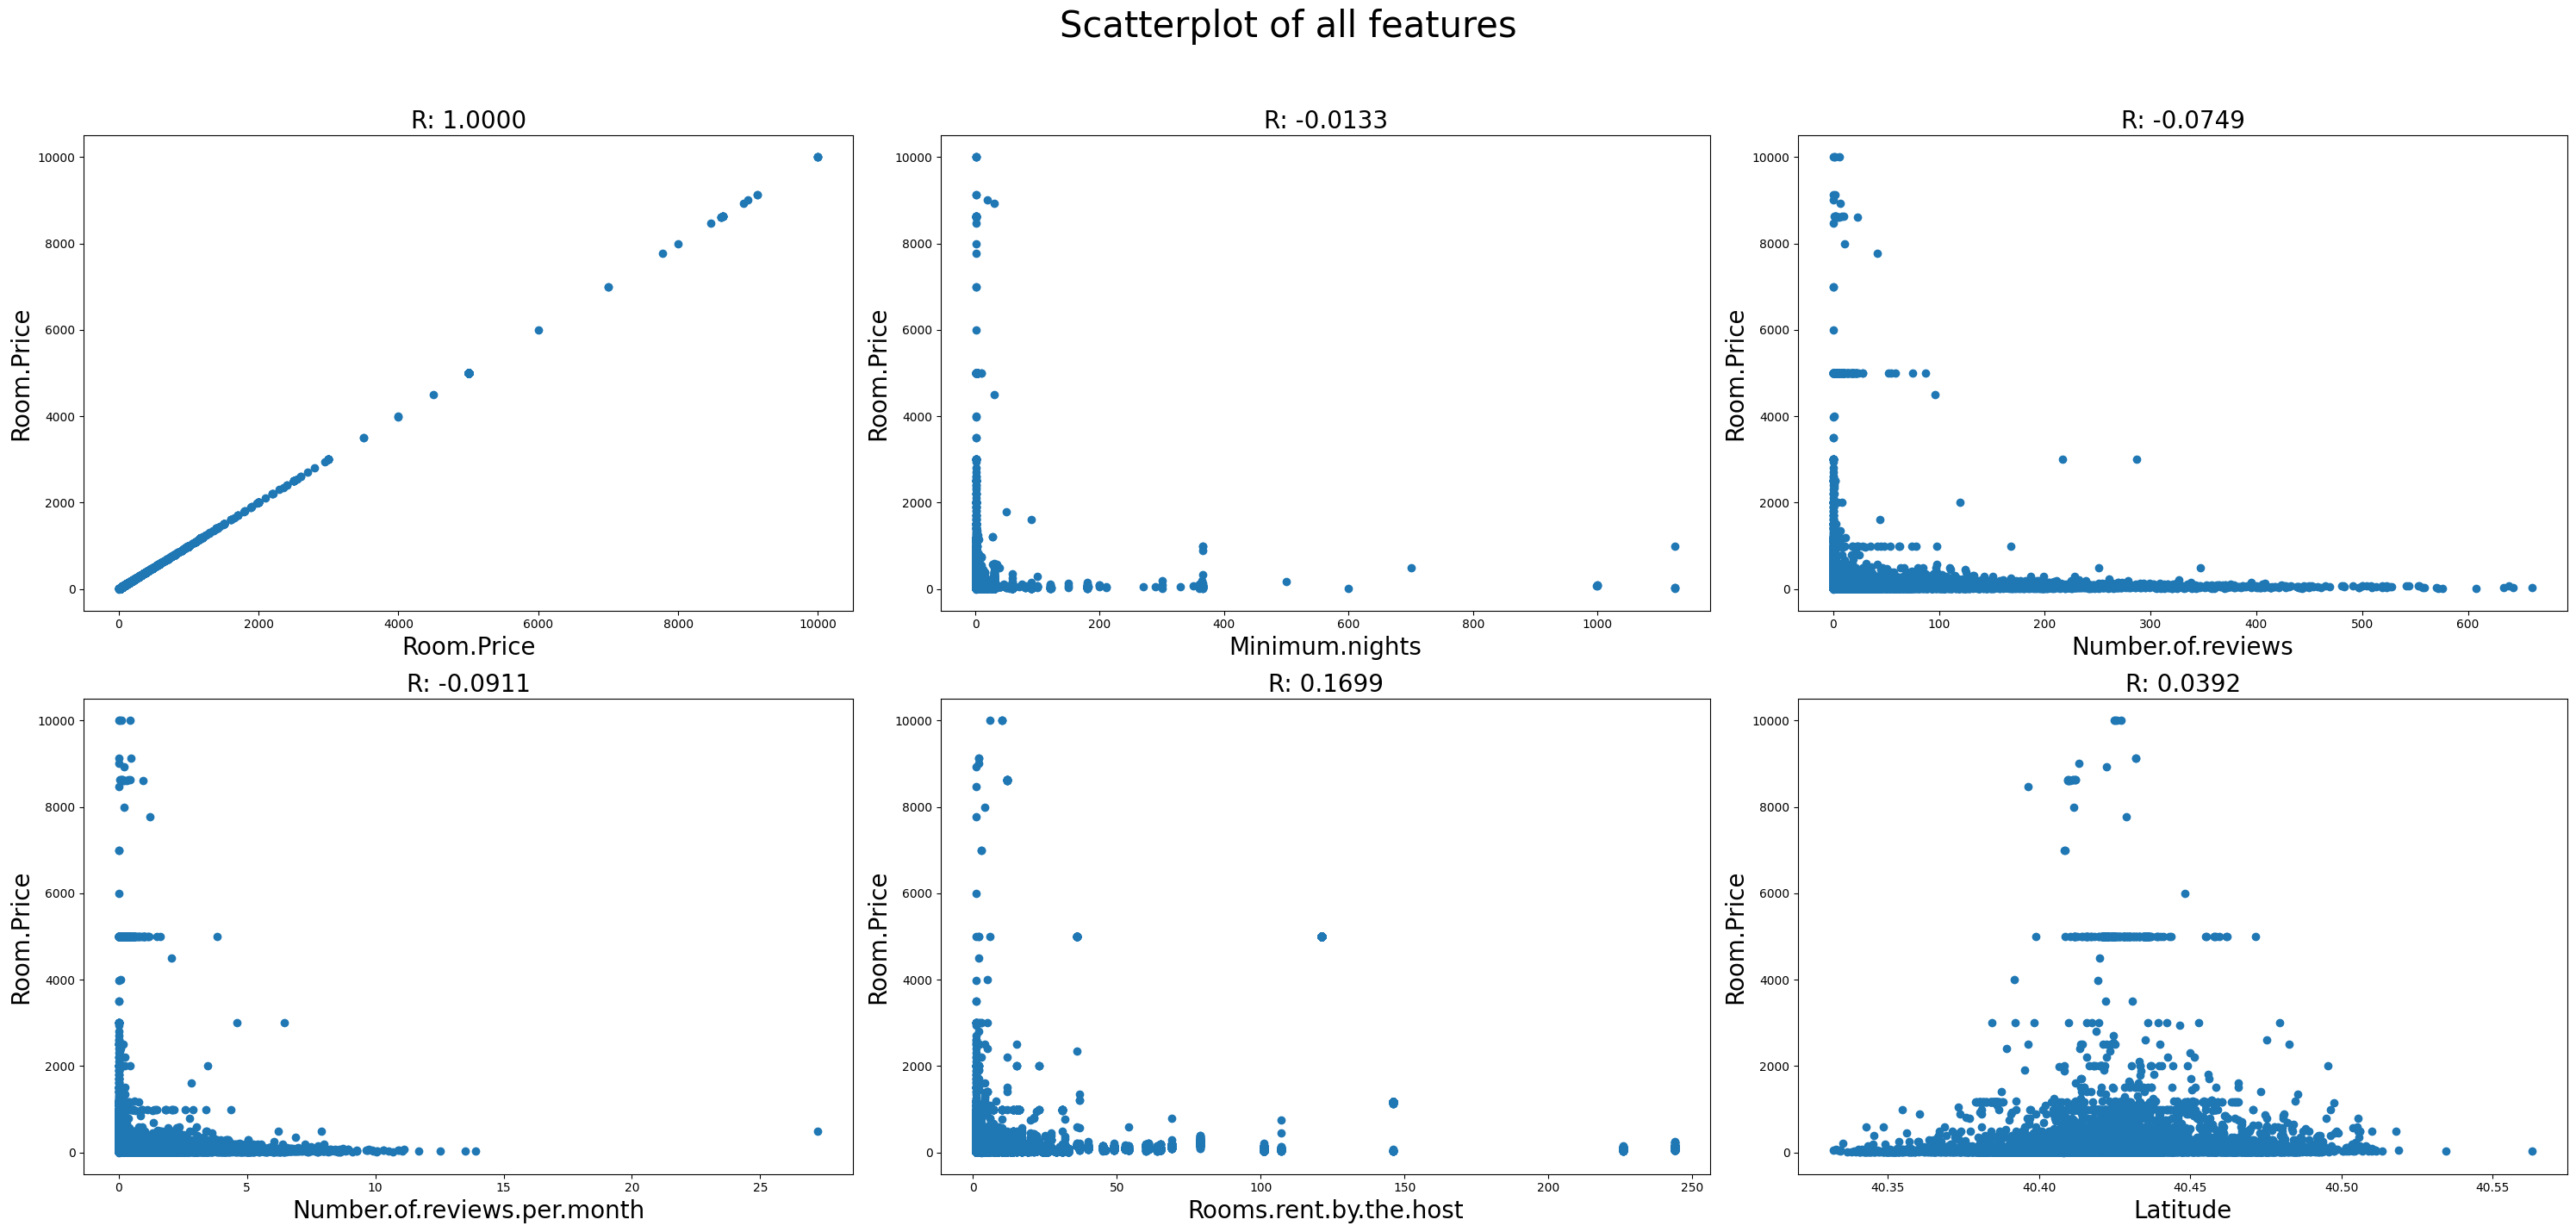

In [19]:
## Column indexer
col_idx = 0

## Create plots with four columns and three rows
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(30, 15))

## Loop through each subplot to make scatterplot
for i in range(2):
    for j in range(3):
        if col_idx < len(Num_data.columns):
            col = Num_data.columns[col_idx]
            if np.issubdtype(Num_data[col].dtype, np.number):  # Check if column is numeric
                axes[i, j].plot(Num_data[col], Num_data['Room.Price'], 'o', color='tab:blue')
                axes[i, j].set_xlabel(Num_data.columns[col_idx], fontsize=20)
                axes[i, j].set_ylabel('Room.Price', fontsize=20)
                axes[i, j].set_title('R: {:.4f}'.format(Num_data[['Room.Price', col]].corr().iloc[0, 1]), fontsize=20)
                fig.suptitle('Scatterplot of all features', fontsize=30)
            col_idx += 1
        else:
            axes[i, j].axis('off')  # Turn off axis if no more columns are available

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

Room.Price                     1.000000
Rooms.rent.by.the.host         0.169926
Longitude                      0.040240
Latitude                       0.039231
Minimum.nights                -0.013299
Number.of.reviews             -0.074905
Number.of.reviews.per.month   -0.091059
Name: Room.Price, dtype: float64


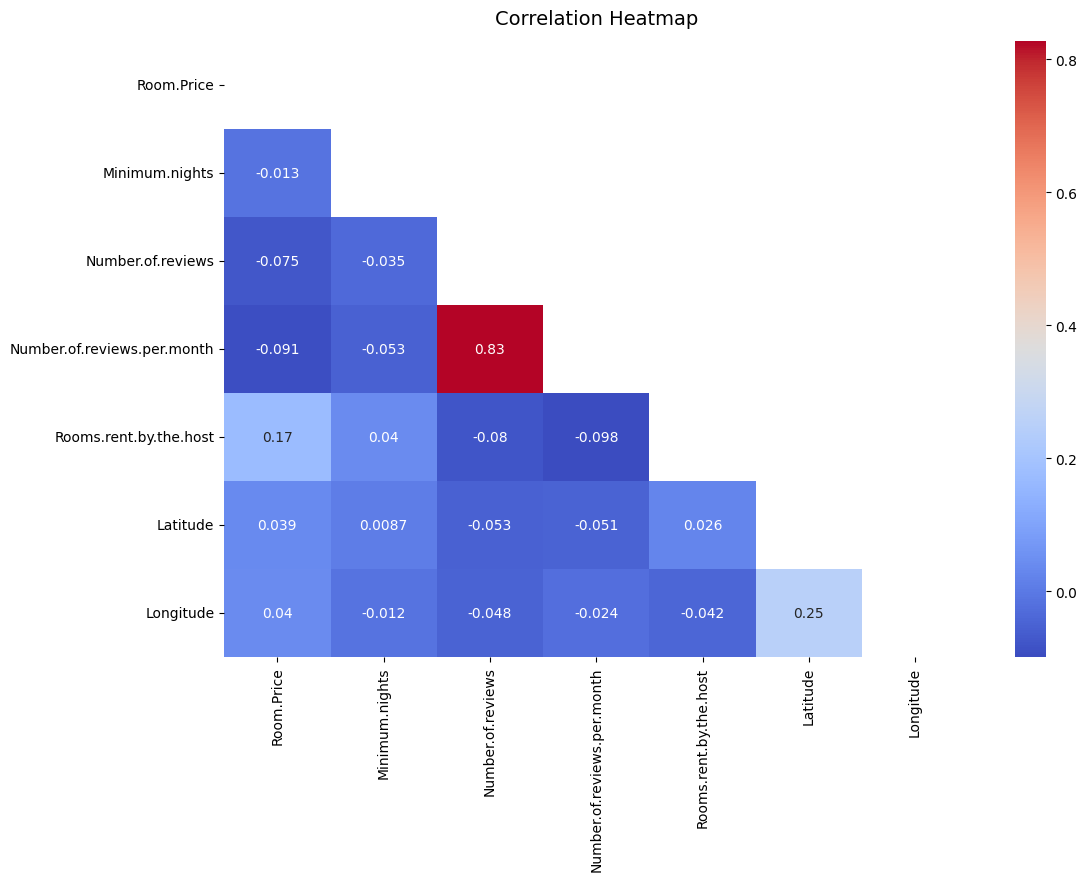

In [20]:
# Calcular la correlación
correlation_matrix = Num_data.corr()
print(correlation_matrix['Room.Price'].sort_values(ascending=False))

# Crear la máscara
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Visualizar la matriz de correlación
plt.figure(figsize=(12, 8))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', mask=mask)
ax.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12)
plt.show()

**Observaciones:**

#### 4.4.3 Análisis de Varianza (ANOVA) para Variables Categóricas

Análisis de Varianza (ANOVA) para Variables Categóricas
Evaluemos las variables categóricas (Neighbourhood, Room.type, City, Country, Availability_Cat, Review_category, Review_Count_Category, Time_category) con ANOVA para ver si tienen una relación significativa con Room.Price.

In [21]:
# Reemplazar los puntos en los nombres de las columnas con guiones bajos
df_airbnb_clean_vs_1.columns = df_airbnb_clean_vs_1.columns.str.replace('.', '_')

In [22]:
# Realizar ANOVA para cada variable categórica
anova_results = {}

for var in df_airbnb_clean_vs_1.columns:
    if var != 'Room_Price':
        model = ols(f'Room_Price ~ {var}', data=df_airbnb_clean_vs_1).fit()
        anova_table = sm.stats.anova_lm(model, typ=2)
        anova_results[var] = anova_table

# Mostrar resultados
for var, anova_table in anova_results.items():
    print(f"ANOVA results for {var}:")
    print(anova_table)
    print("\n")

ANOVA results for Neighbourhood:
                     sum_sq       df         F        PR(>F)
Neighbourhood  1.724252e+08    126.0  4.461674  2.151438e-55
Residual       6.480234e+09  21128.0       NaN           NaN


ANOVA results for Room_type:
                 sum_sq       df          F        PR(>F)
Room_type  6.411966e+07      3.0  68.938242  2.331318e-44
Residual   6.588539e+09  21251.0        NaN           NaN


ANOVA results for Minimum_nights:
                      sum_sq       df         F    PR(>F)
Minimum_nights  1.176598e+06      1.0  3.759499  0.052522
Residual        6.651482e+09  21253.0       NaN       NaN


ANOVA results for Number_of_reviews:
                         sum_sq       df           F        PR(>F)
Number_of_reviews  3.732673e+07      1.0  119.919142  7.820650e-28
Residual           6.615332e+09  21253.0         NaN           NaN


ANOVA results for Number_of_reviews_per_month:
                                   sum_sq       df           F        PR(>F)
Num

**Observaaciones:**
* Room_type: Con un valor F de 68.94 y un valor p extremadamente pequeño (2.33e-44), esto indica que el tipo de habitación tiene un efecto significativo en el precio de la habitación.

* Number_of_reviews: Con un valor F de 119.92 y un valor p extremadamente pequeño (7.82e-28), esto indica que el número de revisiones tiene un efecto significativo en el precio de la habitación.

* Number_of_reviews_per_month: Con un valor F de 177.70 y un valor p extremadamente pequeño (2.24e-40), esto indica que el número de revisiones por mes tiene un efecto significativo en el precio de la habitación.

* Rooms_rent_by_the_host: Con un valor F de 631.93 y un valor p extremadamente pequeño (1.93e-137), esto indica que el número de habitaciones alquiladas por el anfitrión tiene un efecto significativo en el precio de la habitación.

* Latitude y Longitude: Ambas tienen valores F significativos y valores p muy pequeños, lo que indica que la ubicación geográfica de la habitación (latitud y longitud) tiene un efecto significativo en el precio de la habitación.

* Availability_Cat, Review_category, Review_Count_Category, y Time_category: Todas estas variables tienen valores F significativos y valores p muy pequeños, lo que indica que tienen un efecto significativo en el precio de la habitación.

En resumen, todas las variables, excepto Minimum_nights, parecen tener un efecto significativo en el precio de la habitación, según los resultados de ANOVA.